In [1]:
# general tools
import sys
from glob import glob

# data tools
import time
import h5py
import random
import numpy as np
from random import shuffle

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# deep learning tools
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
tf.config.run_functions_eagerly(True)

# from keras_unet_collection import models as k_models
from keras_unet_collection import utils as k_utils
# from keras_unet_collection import layer_utils as k_layers
# from keras_unet_collection.activations import GELU

2022-09-20 14:10:21.586617: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [3]:
sys.path.insert(0, '/glade/u/home/ksha/NCAR/')
sys.path.insert(0, '/glade/u/home/ksha/NCAR/libs/')

from namelist import *
import data_utils as du
import graph_utils as gu
import convnext_keras as ck

from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
%matplotlib inline



In [4]:
from importlib import reload
reload(ck)

<module 'convnext_keras' from '/glade/u/home/ksha/NCAR/libs/convnext_keras.py'>

In [5]:
filename_neg_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/*neg_neg_neg*.npy"))
filename_pos_train = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/*pos*.npy"))

In [6]:
filename_neg_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/VALID*neg_neg_neg*.npy"))
filename_pos_valid = sorted(glob("/glade/scratch/ksha/DATA/NCAR_batch2/VALID*pos*.npy"))

In [7]:
filename_valid = filename_neg_valid + filename_pos_valid

In [8]:
for name in filename_neg_train:
    m = np.sum(np.load(filename_pos_valid[3], allow_pickle=True)[()]['code'])
    if m > 0:
        print(name)

In [16]:
with h5py.File(save_dir+'HRRR_domain.hdf', 'r') as h5io:
    lon_3km = h5io['lon_3km'][...]
    lat_3km = h5io['lat_3km'][...]
    lon_72km = h5io['lon_72km'][...]
    lat_72km = h5io['lat_72km'][...]
    land_mask_72km = h5io['land_mask_72km'][...]
    land_mask_3km = h5io['land_mask_3km'][...]

In [17]:
lon_72km.shape

(44, 75)

In [9]:
#ind_pick_from_batch = [2, 11, 17, 18]

L_vars = 4
L_vars_h = 4
L_vars_ori = 19

In [10]:
L_valid = len(filename_valid)

TEST_input = np.empty((L_valid, 4, 64))
TEST_target = np.ones(L_valid)

for i, name in enumerate(filename_valid):
    
    collection = np.load(name, allow_pickle=True)[()]
    
    vector_gn2 = collection['Gn2']
    vector_gn1 = collection['Gn1']
    vector_gp0 = collection['Gp0']
    vector_gp1 = collection['Gp1']
     
    TEST_input[i, 0, :] = vector_gn2
    TEST_input[i, 1, :] = vector_gn1
    TEST_input[i, 2, :] = vector_gp0
    TEST_input[i, 3, :] = vector_gp1
    
    if 'pos' in name:
        TEST_target[i] = 1.0
    else:
        TEST_target[i] = 0.0

In [11]:
prob_base = np.sum(TEST_target) / len(TEST_target)

In [12]:
prob_base

0.003781148922600337

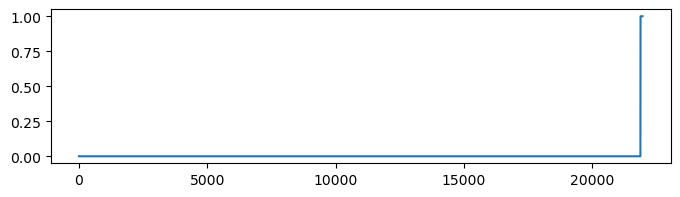

In [13]:
plt.figure(figsize=(8, 2))
plt.plot(TEST_target)

In [14]:
len(filename_pos_valid)

83

In [15]:
len(filename_neg_valid)

21868

**ConvNext**

In [24]:
from sklearn.metrics import brier_score_loss

def verif_metric(VALID_target, Y_pred, thres=0.5):

    tn, fp, fn, tp = confusion_matrix(VALID_target.ravel(), Y_pred.ravel()>thres).ravel()

    CSI = tp/(tp+fn+fp)
    CSI_metric = 1 - CSI

    fpr, tpr, thresholds = roc_curve(VALID_target.ravel(), Y_pred.ravel())
    AUC = auc(fpr, tpr)
    AUC_metric = 1 - AUC
    
    freq = (tp+fp)/(tp+fn)
    freq_metric = np.abs(freq-1.0)
    
    BS = brier_score_loss(VALID_target.ravel(), Y_pred.ravel())
    
    print('{} {} {} {}'.format(CSI, AUC, freq, BS))
    metric = AUC_metric + 2*BS


    return metric


# def verif_metric(VALID_target, Y_pred, prob_base):
#     BS = np.mean((Y_pred.ravel()-VALID_target.ravel())**2)
#     BSS = 1-(BS/prob_base)
#     print('BS = {}; BSS = {}'.format(BS, BSS))
#     return BS/prob_base

In [25]:
from tensorflow.keras import Model

In [48]:
IN = tf.keras.Input(shape=(4, 64))

X = IN

X = tf.keras.layers.Conv1D(64, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(128, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

#X = tf.keras.layers.Dropout(0.1)(X)

X = tf.keras.layers.Conv1D(256, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(128, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Conv1D(64, kernel_size=2, padding="same",)(X)
X = layers.Activation("gelu")(X)
X = layers.LayerNormalization(epsilon=1e-6)(X)

X = tf.keras.layers.Flatten()(X)

OUT = X

OUT = layers.Dense(64)(OUT)
OUT = layers.Activation("gelu")(OUT)
OUT = layers.LayerNormalization(epsilon=1e-6)(OUT)

OUT = layers.Dense(1, activation='sigmoid')(OUT)

model = Model(inputs=IN, outputs=OUT)

In [49]:
tol = 0
min_del = 0
max_tol = 500 # early stopping with patience
epochs = 500
L_train = 100
batch_size = 100
batch_size_half = 50

In [62]:
batch_dir = '/glade/scratch/ksha/DATA/NCAR_batch/'
temp_dir = '/glade/work/ksha/NCAR/Keras_models/'

key = 'SEQ_S'

model_name = '{}_pp4_tune11'.format(key)
model_path = temp_dir+model_name

W_new = model.get_weights()
W_old = k_utils.dummy_loader(temp_dir+'SEQ_S_pp4_tune9')

for l in range(len(W_new)):
    if W_new[l].shape == W_old[l].shape:
        W_new[l] = W_old[l]

model.set_weights(W_new)


In [63]:
model.compile(loss=keras.losses.mean_absolute_error, optimizer=keras.optimizers.SGD(lr=1e-5))

In [64]:
X_batch = np.empty((batch_size, 4, 64))
Y_batch = np.empty((batch_size, 1))
X_batch[...] = np.nan
Y_batch[...] = np.nan

In [65]:
Y_pred = model.predict([TEST_input,])

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


In [66]:
Y_pred[Y_pred<0] = 0
Y_pred[Y_pred>1] = 1
record_temp = verif_metric(TEST_target, Y_pred)
record = record_temp
print("Initial record: {}".format(record))

0.017391304347826087 0.8716984271455677 0.40963855421686746 0.004504105874436079
Initial record: 0.13730978460330448


In [67]:
#verif_metric(TEST_target, Y_pred, thres=0.5)

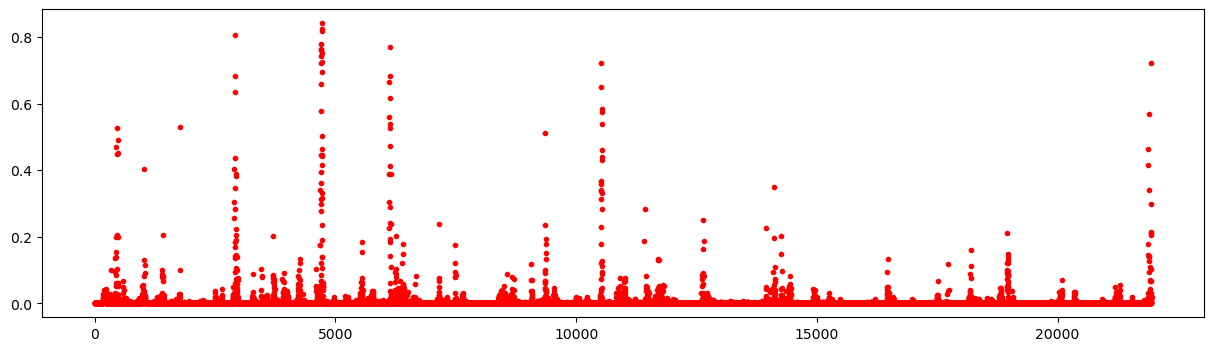

In [68]:
plt.figure(figsize=(15, 4))
#plt.plot(TEST_target[:], 'b-', lw=3.0)
plt.plot(Y_pred[:], 'r.')
#plt.plot(Y_pred>0.5)

In [69]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [46]:
# ========== Training loop ========== #



for i in range(epochs):
    
    shuffle(filename_neg_train)
    shuffle(filename_pos_train)
    
    #print('epoch = {}'.format(i))
    start_time = time.time()
    
    # loop of batch
    for j in range(L_train):
        
        N_aug = int(np.random.uniform(16, 19))
        N_storm = 100 - N_aug

        L_storm = len(filename_neg_train)
        L_aug = len(filename_pos_train)
        
        ind_storm = du.shuffle_ind(L_storm)
        ind_aug = du.shuffle_ind(L_aug)
        
        file_pick_storm = []
        for ind_temp in ind_storm[:N_storm]:
            file_pick_storm.append(filename_neg_train[ind_temp])

        file_pick_aug = []
        for ind_temp in ind_aug[:N_aug]:
            file_pick_aug.append(filename_pos_train[ind_temp])
        
        file_pick = file_pick_storm + file_pick_aug
        
        if len(file_pick) != 100:
            sregwet
        
        for k in range(batch_size):
            
            collection = np.load(file_pick[k], allow_pickle=True)[()]
    
            vector_gn2 = collection['Gn2']
            vector_gn1 = collection['Gn1']
            vector_gp0 = collection['Gp0']
            vector_gp1 = collection['Gp1']
            
            X_batch[k, 0, :] = vector_gn2
            X_batch[k, 1, :] = vector_gn1
            X_batch[k, 2, :] = vector_gp0
            X_batch[k, 3, :] = vector_gp1

            if 'pos' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.9999, 1.0)
            elif 'neg_neg_neg' in file_pick[k]:
                Y_batch[k, :] = np.random.uniform(0.0, 0.0001)
            else:
                werhgaer
                
        #Y_batch_cate = tf.keras.utils.to_categorical(Y_batch)
        
        # # add noise within sparse inputs
        # for v in flag_sparse:
        #     X_batch[..., v] += np.random.uniform(0, 0.01, size=(batch_size, 128, 128))

        # shuffle indices
        ind_ = du.shuffle_ind(batch_size)
        X_batch = X_batch[ind_, ...]
        Y_batch = Y_batch[ind_, :]
        
        if np.sum(np.isnan(X_batch)) > 0:
            asfeargagqarew
        
        # train on batch
        model.train_on_batch([X_batch,], [Y_batch,]);
    
    # epoch end operations
    Y_pred = model.predict([TEST_input,])
    Y_pred[Y_pred<0.0] = 0
    Y_pred[Y_pred>1] = 1
    #Y_pred = Y_pred[:, -1]
    
    record_temp = verif_metric(TEST_target, Y_pred)
    
    # if i % 10 == 0:
    #     model.save(model_path_backup)
    
    if (record - record_temp > min_del) and (np.max(Y_pred) > 0.5):
        print('Validation loss improved from {} to {}'.format(record, record_temp))
        record = record_temp
        tol = 0
        #print('tol: {}'.format(tol))
        # save
        print('save to: {}'.format(model_path))
        model.save(model_path)
    else:
        print('Validation loss {} NOT improved'.format(record_temp))
        tol += 1
        #print('tol: {}'.format(tol))
        if tol >= max_tol:
            print('Early stopping')
            sys.exit();
        else:
            #print('Pass to the next epoch')
            continue;
    print("--- %s seconds ---" % (time.time() - start_time))

/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.047872340425531915 0.8724752678171989 1.3734939759036144 0.006777848199756797
Validation loss 0.14108042858231473 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.051351351351351354 0.8728758090712954 3.6867469879518073 0.013108146336215496
Validation loss 0.15334048360113564 NOT improved


/glade/work/ksha/anaconda3/lib/python3.9/site-packages/tensorflow/python/data/ops/dataset_ops.py:3503: UserWarning: Even though the tf.config.experimental_run_functions_eagerly option is set, this option does not apply to tf.data functions. tf.data functions are still traced and executed as graphs.
  warnings.warn(


0.060126582278481014 0.8727760869708943 3.036144578313253 0.011353599859079794
Validation loss 0.14993111274726534 NOT improved



KeyboardInterrupt



In [ ]:
model.save(model_path)

0.07216494845360824 0.8547555871923765 1.5060240963855422 0.008271191126251975

Validation loss improved from 0.16323948442990924 to 0.16178679506012741

save to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5

INFO:tensorflow:Assets written to: /glade/work/ksha/NCAR/Keras_models/SEQ_S_pp4_tune5/assets

### Verification

In [55]:
from sklearn.metrics import classification_report, auc, roc_curve
from sklearn.metrics import confusion_matrix

In [58]:
from sklearn.calibration import calibration_curve

In [77]:
print(classification_report(Y_pred.ravel() > 0.5, TEST_target.ravel()))

              precision    recall  f1-score   support

       False       1.00      1.00      1.00     21917
        True       0.02      0.06      0.03        34

    accuracy                           0.99     21951
   macro avg       0.51      0.53      0.52     21951
weighted avg       1.00      0.99      1.00     21951



In [74]:
prob_true, prob_pred = calibration_curve(TEST_target.ravel(), Y_pred.ravel(), n_bins=10)

In [75]:
o_bar_ = np.mean(TEST_target.ravel())

(0.0, 1.0)

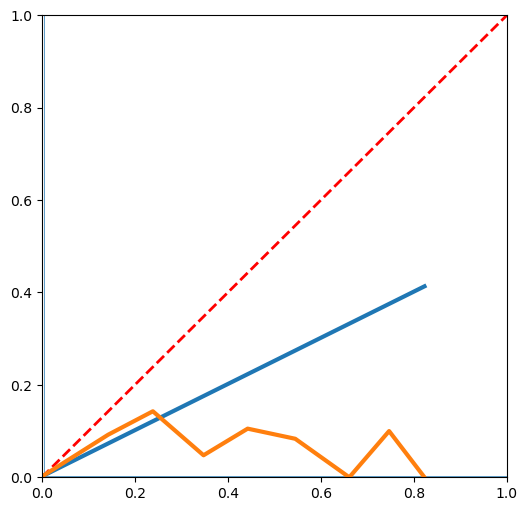

In [83]:
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()


ax.plot(prob_pred, 0.5*prob_pred + 0.5*o_bar_, lw=3.0)

ax.plot(np.linspace(0, 1, 10), np.linspace(0, 1, 10), 'r--', lw=2.0)

ax.axhline(o_bar_, lw=0.5)
ax.axvline(o_bar_, lw=0.5)

plt.plot(prob_pred, prob_true, lw=3)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])

In [85]:
CSI = []
POFD = []
AUC = []
freq = []

thress = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7]

for i, thres in enumerate(thress):

    Y_pred_label = Y_pred.ravel() > thres
    
    tn, fp, fn, tp = confusion_matrix(TEST_target.ravel(), Y_pred_label).ravel()
    CSI.append(tp/(tp+fn+fp))
    POFD.append(fp/(tn+fp))
    # fpr, tpr, thresholds = roc_curve(Y_true_point.ravel(), Y_pred_label.ravel())
    # AUC.append(auc(fpr, tpr))
    freq.append((tp+fp)/(tp+fn))
    

Text(0, 0.5, 'CSI')

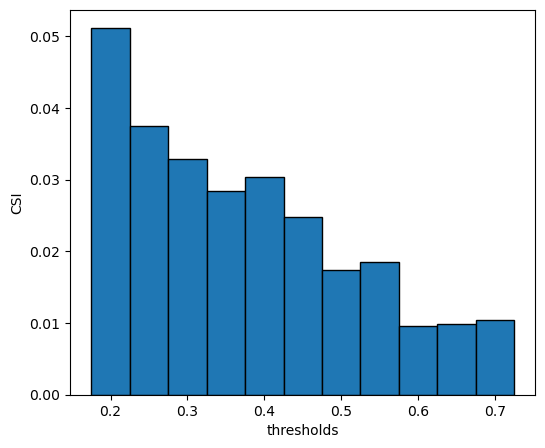

In [86]:
plt.figure(figsize=(6, 5))
plt.bar(thress, CSI, width=0.05, edgecolor='k')
plt.xlabel('thresholds')
plt.ylabel('CSI')

In [ ]:
import tf.keras.backend as K

In [ ]:
def custom_loss(y_true, y_pred):
            
    y_pred_neg = y_pred[y_true == 0]
    y_pred_pos = y_pred[y_true == 1]
    
    loss = 0.1*K.mean(y_pred_neg) + K.mean(K.abs(y_pred_pos-1))
        
    return loss